In [1]:
%reset -f

In [2]:
import torch
import torch.nn as nn
import numpy as np
import scipy.io as reader
from matplotlib import pyplot as plt 
import utils

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [3]:
class Net(nn.Module):
    def __init__(self, layers):
        super(Net, self).__init__()
        self.layers = layers
        self.activation = nn.Tanh()
        self.linear = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        for i in range(len(layers) - 1):
            nn.init.xavier_normal_(self.linear[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linear[i].bias.data)
    def forward(self, x):
        a = self.activation(self.linear[0](x))
        for i in range(1, len(self.layers) - 2):
            z = self.linear[i](a)
            a = self.activation(z)
        a = self.linear[-1](a)
        return a

In [4]:
def get_possion_data(Nf, Nt):
    x_f = torch.linspace(-1, 1, Nf).unsqueeze(-1).to(device)
    x_test = torch.linspace(-1, 1, Nt).unsqueeze(-1).to(device)
    x_test_exact = 0.1 * torch.sin(4 * torch.pi * x_test) + torch.tanh(50 * x_test)
    x_test_exact = x_test_exact.to(device)
    x_label = torch.tensor([[-1], [1]]).float().to(device)
    x_labels = 0.1 * torch.sin(4 * torch.pi * x_label) + torch.tanh(50 * x_label)
    x_labels = x_labels.to(device)
    return x_f, x_test, x_test_exact, x_label, x_labels

In [5]:
Nf = 400
Nt = 10000
x, x_test_point, x_test_exact, x_bc, u_bc = get_possion_data(Nf, Nt)

In [6]:
# 载入best_model.pth
layers = [1, 20, 20, 20, 20, 1]
net = Net(layers)
net.load_state_dict(torch.load('./best_model.pth'))
net.to(device)

Net(
  (activation): Tanh()
  (linear): ModuleList(
    (0): Linear(in_features=1, out_features=20, bias=True)
    (1-3): 3 x Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
x_test_pred = net(x_test_point)

In [8]:
j0 = 0
J = 5
e = 0.003

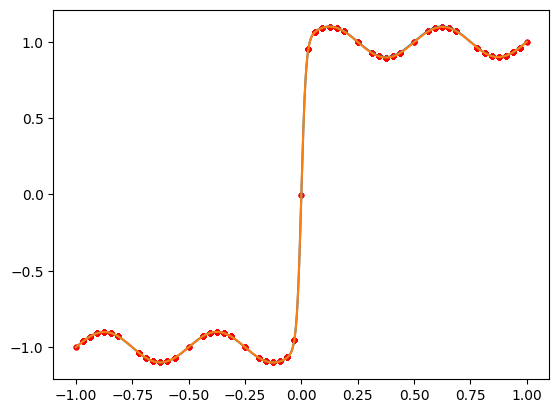

In [9]:
plt.plot(x_test_point.detach().cpu().numpy(), x_test_exact.detach().cpu().numpy(), label='PINN')
plt.plot(x_test_point.detach().cpu().numpy(), x_test_pred.detach().cpu().numpy(), label='True')

iwtmodel = utils.torchIWT(j0, J, e)
iwtmodel = iwtmodel.to(device)
approx, indicies = iwtmodel.get_Iwt2d(x_test_pred, x_test_point, torch.tensor([[1.0]]).to(device))

idxn = []
for i in indicies:
    idxn = idxn + i
idxn = torch.tensor(idxn).to(device).float()
# 突出显示的点
plt.scatter(x_test_point[idxn[:,0].long()].detach().cpu().numpy(), x_test_pred[idxn[:,0].long()].detach().cpu().numpy(), c='r', s=10, label='IWT')

In [10]:
err = np.linalg.norm(x_test_pred.cpu().detach().numpy() - x_test_exact.cpu().detach().numpy(), 2) / np.linalg.norm(x_test_exact.cpu().detach().numpy(), 2)
print('Relative L2 error: {:.4e}'.format(err))

Relative L2 error: 1.6052e-03
